In [1]:
repo_path = '/home/ajhnam/plinko_nn'

In [2]:
import sys
sys.path.append(repo_path + '/src')
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.min_rows = 20
pd.options.display.max_rows = 100

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from plinko.misc import data_utils
from plinko.misc.simulation_dataset import SimulationDataset
from plinko.model.predictor_gru import GRUPredictor
from plinko.misc import plot as plinko_plot
from plinko.model.mlp import MLP
from plinko.misc import utils
from plotnine import *
import math
from plinko.simulation import utils as sim_utils
import pymunk
from plinko.misc.data_utils import make_shape_df
from sklearn.model_selection import train_test_split

from torch.distributions.normal import Normal

Loading chipmunk for Linux (64bit) [/home/ajhnam/anaconda3/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [3]:
device = 0
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_tensor_type('torch.FloatTensor')
epsilon = sys.float_info.epsilon

In [4]:
df_ball = pd.read_feather(repo_path + '/data/simulations/sim_ball.feather')
df_env = pd.read_feather(repo_path + '/data/simulations/sim_environment.feather')
df_col = pd.read_feather(repo_path + '/data/simulations/sim_collisions.feather')

In [5]:
def make_shape_df(df_env):
    """
    Generates a dataframe that converts shape info in df_env into vertices for each shape
    Assumes that angles are in [0, 2pi]
    """
    triangles = get_env_vertices('triangle', 3, df_env)
    rectangles = get_env_vertices('rectangle', 4, df_env)
    pentagons = get_env_vertices('pentagon', 5, df_env)
    
    shapes = df_env[['simulation']]
    add_shapes(shapes, 'triangle', triangles)
    add_shapes(shapes, 'rectangle', rectangles)
    add_shapes(shapes, 'pentagon', pentagons)
    return shapes


def get_vertices(ngon, radius, x, y, angle):
    """
    ngon: number of sides of the polygon
    Assumes that angles are in [0, 2pi]
    """
    rigid_body = pymunk.Body(body_type=pymunk.Body.STATIC)
    polygon = sim_utils.generate_ngon(ngon, radius)
    shape = pymunk.Poly(rigid_body, polygon)
    rigid_body.pos = (x, y)
    rigid_body.angle = angle

    vertices = []
    for v in shape.get_vertices():
        x,y = v.rotated(shape.body.angle) + shape.body.pos
        vertices.append([x, y])
    return np.array(vertices)


def add_shapes(shapes_df, shape_name, vertices):
    """
    Helper function for make_shape_df
    vertices shape: [batch_size, ngon, 2]
    """
    for i in range(vertices.shape[1]):
        shapes_df['{}_vx{}'.format(shape_name, i)] = vertices[:,i,0]
        shapes_df['{}_vy{}'.format(shape_name, i)] = vertices[:,i,1]


def get_env_vertices(shape, ngon, df_env):
    """
    Helper function for make_shape_df
    """
    vertices = []
    for x, y, r in df_env[[shape + '_x', shape + '_y', shape + '_r']].values:
        vertices.append(get_vertices(ngon, 50, x, y, r))
    vertices = np.stack(vertices)
    return vertices

In [6]:
shapes = make_shape_df(df_env)
shapes.to_feather('shapes.feather')

In [7]:
dim_divisor = 700

df_ball.px /= dim_divisor
df_ball.py /= dim_divisor
df_ball.vx /= dim_divisor
df_ball.vy /= dim_divisor

for col in df_env.columns:
    if '_x' in col or '_y' in col:
        df_env[col] /= dim_divisor
    elif '_r' in col:
        df_env[col] /= 2*math.pi
        
for col in shapes.columns:
    if '_' in col:
        shapes[col] /= dim_divisor

In [8]:
num_samples = 2000
collisions = df_col.copy()
collisions = collisions.rename({'object': 'collision'}, axis=1)
collisions.t -= 1

collisions = df_ball.merge(collisions, how='left')
collisions.collision[collisions.collision.isna()] = 'none'
collisions.collision[(collisions.collision == 'walls') & (collisions.px < 200/dim_divisor)] = 'left_wall'
collisions.collision[(collisions.collision == 'walls') & (collisions.px > 500/dim_divisor)] = 'right_wall'
collisions = collisions.groupby('collision', as_index=False).apply(lambda x: x.sample(num_samples))
collisions = collisions.sort_values(['simulation', 'run', 't'])
collisions = collisions.reset_index(drop=True)

env_columns = ['triangle_x', 'triangle_y', 'triangle_r',
               'rectangle_x', 'rectangle_y', 'rectangle_r',
               'pentagon_x', 'pentagon_y','pentagon_r']
shape_columns = [c for c in shapes.columns if '_v' in c]

In [9]:
tr_collisions = collisions.groupby('collision', as_index=False).apply(lambda x: x.sample(1800))
tr_keys = {(s,r,t) for s,r,t in tr_collisions[['simulation', 'run', 't']].values}
collisions['train'] = [(s,r,t) in tr_keys for s,r,t in collisions[['simulation', 'run', 't']].values]
te_collisions = collisions[~collisions.train]

tr_envs = tr_collisions.merge(df_env).sort_values(['simulation', 'run', 't'])[env_columns]
tr_shapes = tr_collisions.merge(shapes).sort_values(['simulation', 'run', 't'])[shape_columns]
te_envs = te_collisions.merge(df_env).sort_values(['simulation', 'run', 't'])[env_columns]
te_shapes = te_collisions.merge(shapes).sort_values(['simulation', 'run', 't'])[shape_columns]

idx2col = sorted(collisions.collision.unique())
col2idx = {c: i for c, i in zip(idx2col, range(len(idx2col)))}

tr_states = torch.tensor(tr_collisions[['px', 'py', 'vx', 'vy']].values, dtype=torch.float, device=device)
tr_targets = torch.tensor([col2idx[c] for c in tr_collisions.collision], dtype=torch.long, device=device)
tr_envs = torch.tensor(tr_envs.values, dtype=torch.float, device=device)

tr_triangles = torch.tensor(tr_shapes[[c for c in tr_shapes.columns if 'triangle' in c]].values, dtype=torch.float, device=device)
tr_rectangles = torch.tensor(tr_shapes[[c for c in tr_shapes.columns if 'rectangle' in c]].values, dtype=torch.float, device=device)
tr_pentagons = torch.tensor(tr_shapes[[c for c in tr_shapes.columns if 'pentagon' in c]].values, dtype=torch.float, device=device)

te_states = torch.tensor(te_collisions[['px', 'py', 'vx', 'vy']].values, dtype=torch.float, device=device)
te_targets = torch.tensor([col2idx[c] for c in te_collisions.collision], dtype=torch.long, device=device)
te_envs = torch.tensor(te_envs.values, dtype=torch.float, device=device)

te_triangles = torch.tensor(te_shapes[[c for c in te_shapes.columns if 'triangle' in c]].values, dtype=torch.float, device=device)
te_rectangles = torch.tensor(te_shapes[[c for c in te_shapes.columns if 'rectangle' in c]].values, dtype=torch.float, device=device)
te_pentagons = torch.tensor(te_shapes[[c for c in te_shapes.columns if 'pentagon' in c]].values, dtype=torch.float, device=device)

tr_shape_tensor = torch.cat([tr_triangles, tr_rectangles, tr_pentagons], dim=-1)
te_shape_tensor = torch.cat([te_triangles, te_rectangles, te_pentagons], dim=-1)

In [10]:
def get_accuracy(outputs, targets, dataset):
    corrects = (outputs.argmax(-1) == targets).float()
    accuracy = float(corrects.mean())
    row = {'epoch': epoch, 'dataset': dataset, 'loss': loss, 'acc_total': accuracy}
    for idx in range(len(idx2col)):
        row['acc_' + idx2col[idx]] = float(corrects[targets == idx].mean())
    return accuracy, row

In [152]:
model = MLP(input_size=[24, 4],
            hidden_layer_size=[96, 96, 96, 96],
            output_size=len(idx2col)).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=.001)
epochs = 10000

rows = []
for epoch in tqdm(range(epochs+1)):
    optimizer.zero_grad()
    outputs = model(tr_shape_tensor, tr_states)
    loss = F.cross_entropy(outputs, tr_targets)
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        loss = float(loss)
        tr_accuracy, tr_row = get_accuracy(outputs, tr_targets, 'train')
        outputs = model(te_shape_tensor, te_states)
        te_accuracy, te_row = get_accuracy(outputs, te_targets, 'test')
        rows.append(tr_row)
        rows.append(te_row)
        
    if epoch%500 == 0:
        print(epoch, round(loss, 4), round(tr_accuracy, 4), round(te_accuracy, 4))
        
summary = pd.DataFrame(rows)

0 1.9478 0.1429 0.143
500 0.9116 0.6497 0.6426
1000 0.8817 0.6575 0.664
1500 0.8377 0.6752 0.6548
2000 0.8077 0.6926 0.659
2500 0.784 0.7037 0.6505
3000 0.7528 0.7204 0.6619
3500 0.7336 0.729 0.6619
4000 0.5031 0.8084 0.659
4500 0.4779 0.8186 0.6605
5000 0.4592 0.829 0.6533
5500 0.4449 0.836 0.6562
6000 0.4254 0.8413 0.664
6500 0.404 0.8533 0.6612
7000 0.3807 0.8675 0.6598
7500 0.369 0.8751 0.6619
8000 0.3597 0.877 0.6598
8500 0.338 0.8894 0.6562
9000 0.3241 0.8937 0.6626
9500 0.3058 0.9035 0.6555
10000 0.2947 0.905 0.6569



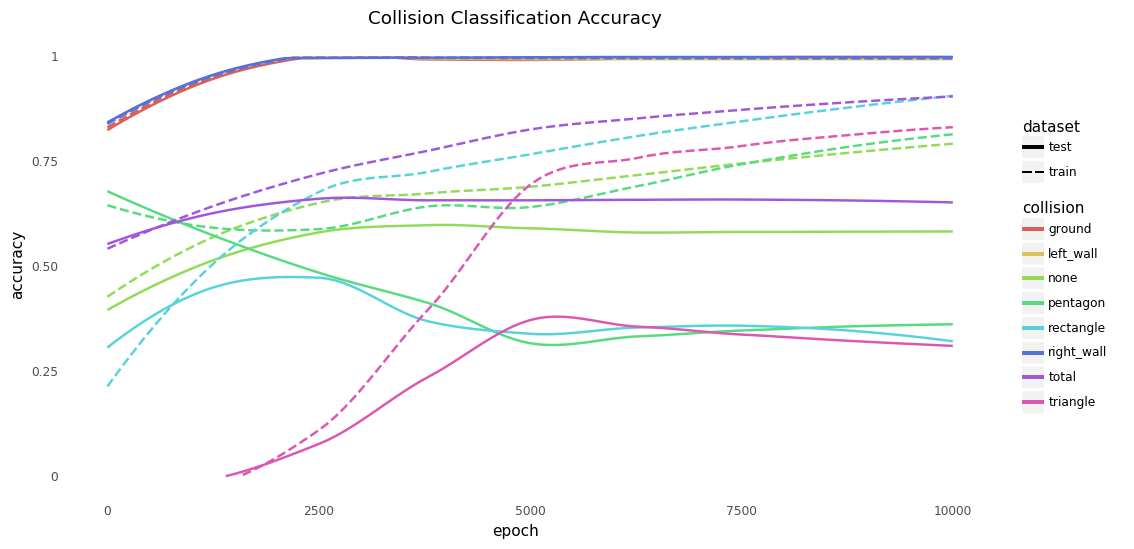

<ggplot: (8774251956569)>

In [158]:
accuracies = summary.drop('loss', axis=1)
accuracies = pd.melt(accuracies, id_vars=['epoch', 'dataset'], var_name='collision')
accuracies.collision = [a[4:] for a in accuracies.collision]
accuracies = accuracies.rename({'value': 'accuracy'}, axis=1)

(ggplot(accuracies)
     + geom_smooth(aes(x='epoch', y='accuracy', color='collision', linetype='dataset'), se=False)
     + labs(title='Collision Classification Accuracy')
     + ylim(0, 1)
     + theme(
             figure_size=(12, 6),
             panel_background=element_blank(),
             line=element_blank(),
             panel_border=element_blank(),
            )
)

In [28]:
class RelationalLayer(nn.Module):
    def __init__(self,
                 object_embed_size,
                 ball_embed_size,
                 output_size
                 ):
        super().__init__()
        self.ball_embed_size = ball_embed_size
        self.object_embed_size = object_embed_size
        self.output_size = output_size

        self.object_embedder = MLP(input_size=6,
                                   hidden_layer_size=[48, 48],
                                   output_size=object_embed_size)
        self.ball_embedder = MLP(input_size=4,
                                 hidden_layer_size=[48, 48],
                                 output_size=ball_embed_size)
        self.mlp = MLP(input_size=[ball_embed_size, object_embed_size],
                       hidden_layer_size=[96, 96, 96],
                       output_size=[output_size, 1])  # vector, score logit

    def forward(self, objects, ball):
        """
        objects: tensor of shape [B, K, Eo] (batch, number of objects, embedding)
        ball: tensor of shape [B, T, Eb] (batch, timesteps, embedding)
        return tensor of shape [B, T, D] (batch, timestemps, output embedding size)
        """
        # want ball: [B, K, Eb]
        # want objects: [B, T, K, Eo]
        B, Eb = ball.shape
        B, K, Eo = objects.shape
        ball_embed = self.ball_embedder(ball)
        object_embed = self.object_embedder(objects)
        ball_embed = utils.expand_along_dim(ball_embed, K, 1)
        h, logit = self.mlp(ball_embed, object_embed)  # h: [B, T, K, D], # logit: [B, T, K, 1]
        scores = logit.squeeze(-1).softmax(-1)  # [B, T, K]
        h = utils.broadcast_multiply(scores, h).sum(-2)
        return h

In [29]:
tr_rl_env = torch.cat([tr_envs.view(-1, 3, 3),
           utils.expand_along_dim(torch.eye(3, device=device), len(tr_envs), 0)], dim=-1)
te_rl_env = torch.cat([te_envs.view(-1, 3, 3),
           utils.expand_along_dim(torch.eye(3, device=device), len(te_envs), 0)], dim=-1)

In [30]:
model = RelationalLayer(object_embed_size=48,
                        ball_embed_size=48,
                        output_size=7).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=.001)
epochs = 10000

rows = []
for epoch in tqdm(range(epochs+1)):
    optimizer.zero_grad()
    outputs = model(tr_rl_env, tr_states)
    loss = F.cross_entropy(outputs, tr_targets)
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        loss = float(loss)
        tr_accuracy, tr_row = get_accuracy(outputs, tr_targets, 'train')
        outputs = model(te_rl_env, te_states)
        te_accuracy, te_row = get_accuracy(outputs, te_targets, 'test')
        rows.append(tr_row)
        rows.append(te_row)
        
    if epoch%500 == 0:
        print(epoch, round(loss, 4), round(tr_accuracy, 4), round(te_accuracy, 4))
        
summary = pd.DataFrame(rows)

0 1.9463 0.1429 0.143
500 0.8831 0.657 0.6576
1000 0.8509 0.6706 0.6783
1500 0.8449 0.6745 0.6833
2000 0.8437 0.6735 0.6848
2500 0.8401 0.6898 0.6826
3000 0.6446 0.6898 0.6926
3500 0.5949 0.709 0.7112
4000 0.589 0.7076 0.7105
4500 0.583 0.7114 0.6984
5000 0.5837 0.7101 0.7148
5500 0.5803 0.7155 0.7177
6000 0.5792 0.7186 0.7162
6500 0.5827 0.7146 0.7055
7000 0.5757 0.7256 0.7191
7500 0.5723 0.7235 0.7191
8000 0.5728 0.7199 0.7169
8500 0.5754 0.7215 0.7212
9000 0.5691 0.7256 0.7162
9500 0.5677 0.7276 0.7219
10000 0.5671 0.7284 0.7241



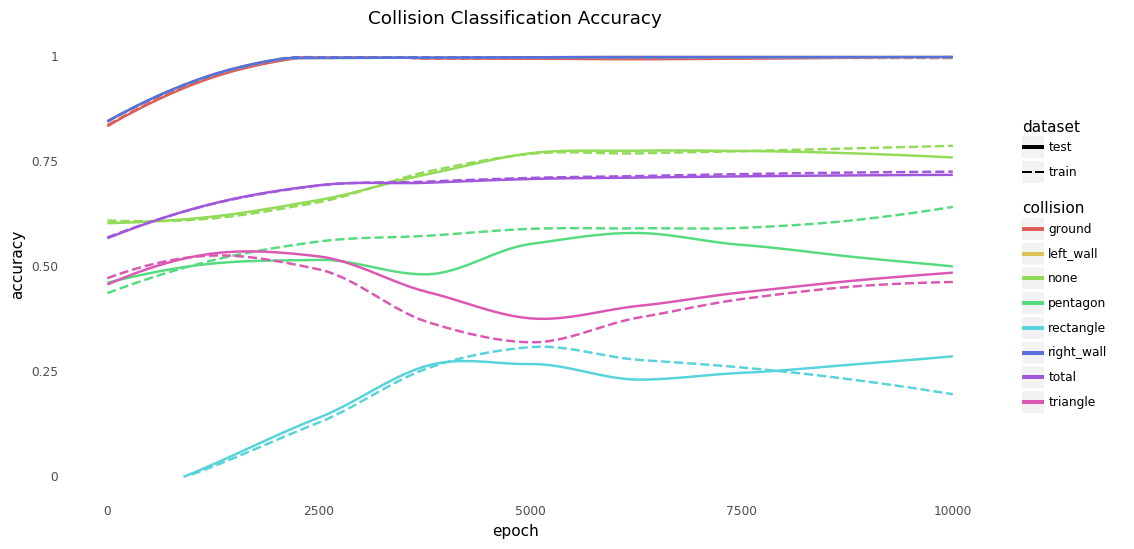

<ggplot: (8739738484361)>

In [31]:
accuracies = summary.drop('loss', axis=1)
accuracies = pd.melt(accuracies, id_vars=['epoch', 'dataset'], var_name='collision')
accuracies.collision = [a[4:] for a in accuracies.collision]
accuracies = accuracies.rename({'value': 'accuracy'}, axis=1)

(ggplot(accuracies)
     + geom_smooth(aes(x='epoch', y='accuracy', color='collision', linetype='dataset'), se=False)
     + labs(title='Collision Classification Accuracy')
     + ylim(0, 1)
     + theme(
             figure_size=(12, 6),
             panel_background=element_blank(),
             line=element_blank(),
             panel_border=element_blank(),
            )
)

In [32]:
class VertexRelationalLayer(nn.Module):
    def __init__(self,
                 object_embed_size,
                 ball_embed_size,
                 embed_hidden_sizes,
                 output_size
                 ):
        super().__init__()
        self.ball_embed_size = ball_embed_size
        self.object_embed_size = object_embed_size
        self.embed_hidden_sizes = embed_hidden_sizes
        self.output_size = output_size

        self.triangle_embedder = MLP(input_size=6,
                                   hidden_layer_size=embed_hidden_sizes,
                                   output_size=object_embed_size)
        self.rectangle_embedder = MLP(input_size=8,
                                   hidden_layer_size=embed_hidden_sizes,
                                   output_size=object_embed_size)
        self.pentagon_embedder = MLP(input_size=10,
                                   hidden_layer_size=embed_hidden_sizes,
                                   output_size=object_embed_size)
        self.ball_embedder = MLP(input_size=4,
                                 hidden_layer_size=embed_hidden_sizes,
                                 output_size=ball_embed_size)
        self.mlp = MLP(input_size=[ball_embed_size, object_embed_size],
                       hidden_layer_size=[96, 96, 96],
                       output_size=[output_size, 1])  # vector, score logit

    def forward(self, triangles, rectangles, pentagons, ball):
        """
        objects: tensor of shape [B, 6/8/10] (batch, number of objects, embedding)
        ball: tensor of shape [B, T, Eb] (batch, timesteps, embedding)
        return tensor of shape [B, T, D] (batch, timestemps, output embedding size)
        """
        # want ball: [B, K, Eb]
        # want objects: [B, K, Eo]
#         B, Eb = ball.shape
        ball_embed = self.ball_embedder(ball)
        triangle_embed = self.triangle_embedder(triangles)
        rectangle_embed = self.rectangle_embedder(rectangles)
        pentagon_embed = self.pentagon_embedder(pentagons)
        objects_embed = torch.stack([triangle_embed, rectangle_embed, pentagon_embed], dim=1)
        ball_embed = utils.expand_along_dim(ball_embed, 3, 1)
        h, logit = self.mlp(ball_embed, objects_embed)  # h: [B, T, K, D], # logit: [B, T, K, 1]
        scores = logit.squeeze(-1).softmax(-1)  # [B, T, K]
        h = utils.broadcast_multiply(scores, h).sum(-2)
        return h

In [36]:
model = VertexRelationalLayer(object_embed_size=48,
                        ball_embed_size=48,
                        embed_hidden_sizes=[48,48],
                        output_size=7).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=.001)
epochs = 10000

rows = []
for epoch in tqdm(range(epochs+1)):
    optimizer.zero_grad()
    outputs = model(tr_triangles, tr_rectangles, tr_pentagons, tr_states.squeeze()).squeeze()
    loss = F.cross_entropy(outputs, tr_targets)
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        loss = float(loss)
        tr_accuracy, tr_row = get_accuracy(outputs, tr_targets, 'train')
        outputs = model(te_triangles, te_rectangles, te_pentagons, te_states.squeeze()).squeeze()
        te_accuracy, te_row = get_accuracy(outputs, te_targets, 'test')
        rows.append(tr_row)
        rows.append(te_row)
        
    if epoch%500 == 0:
        print(epoch, round(loss, 4), round(tr_accuracy, 4), round(te_accuracy, 4))
        
summary = pd.DataFrame(rows)

0 1.9461 0.1429 0.143
500 1.1678 0.5283 0.5297
1000 1.1366 0.547 0.5432
1500 1.1171 0.5577 0.5597
2000 0.8852 0.6982 0.6862
2500 0.8308 0.7029 0.7055
3000 0.8248 0.7108 0.6998
3500 0.8226 0.7056 0.7076
4000 0.6104 0.7171 0.7191
4500 0.5992 0.722 0.7084
5000 0.5914 0.7261 0.7219
5500 0.5893 0.7246 0.7284
6000 0.5868 0.729 0.7227
6500 0.5879 0.7245 0.7205
7000 0.5828 0.7313 0.7262
7500 0.5836 0.731 0.7198
8000 0.5806 0.7328 0.7248
8500 0.5795 0.7312 0.7269
9000 0.5794 0.729 0.7262
9500 0.577 0.732 0.7298
10000 0.576 0.733 0.7291



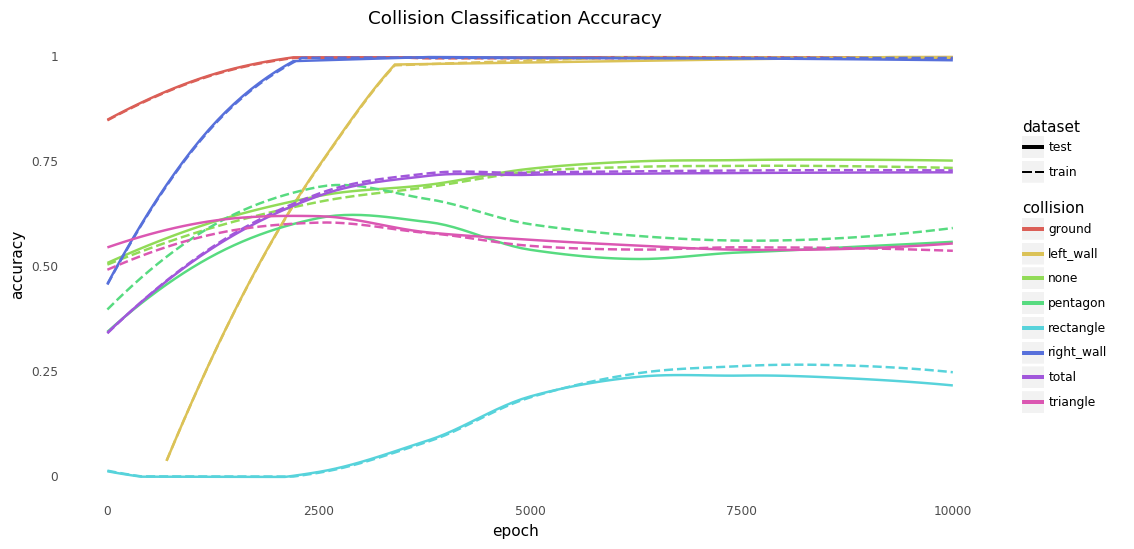

<ggplot: (8739738379117)>

In [37]:
accuracies = summary.drop('loss', axis=1)
accuracies = pd.melt(accuracies, id_vars=['epoch', 'dataset'], var_name='collision')
accuracies.collision = [a[4:] for a in accuracies.collision]
accuracies = accuracies.rename({'value': 'accuracy'}, axis=1)

(ggplot(accuracies)
     + geom_smooth(aes(x='epoch', y='accuracy', color='collision', linetype='dataset'), se=False)
     + labs(title='Collision Classification Accuracy')
     + ylim(0, 1)
     + theme(
             figure_size=(12, 6),
             panel_background=element_blank(),
             line=element_blank(),
             panel_border=element_blank(),
            )
)